In [66]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

import pandas as pd
from scipy.stats import multivariate_normal

try:
    from PIL import Image
except ImportError:
    import Image
    
# resolution of the output images
my_dpi = 200


def transparent_cmap(cmap_name, mode="defaut") :
    #import matplotlib.colors
    #import matplotlib.cm
    #from matplotlib.colors import ListedColormap
    
    # Get original cmap
    cmap_og = plt.get_cmap(cmap_name)
    #cmap_og = cmap_name

    # retrieve rgba values from colormap
    rgba_lin = cmap_og(np.arange(cmap_og.N))
    #print(rgba_lin)
        
    # adds linear alpha without rescaling RGB values
    if mode == "center" :
        rgba_lin[:,-1] = np.concatenate((np.linspace(1, 0, int(cmap_og.N/2)), np.linspace(0, 1, cmap_og.N-int(cmap_og.N/2))))
    elif mode == "compressed" :
        rgba_lin[:,-1] = np.concatenate((np.linspace(0, 1, cmap_og.N-int(cmap_og.N/2)), np.ones(int(cmap_og.N/2))))
    else :
        rgba_lin[:,-1] = np.linspace(0, 1, cmap_og.N)
        
    #rint(rgba_lin)
    
    # save rgba values as colormap
    cmap_lin_alpha = ListedColormap(rgba_lin)
    #plt.figure()
    #plt.imshow([cmap_lin_alpha.colors for i in range(10)])
    
    return cmap_lin_alpha

# location des stations carimam (en pixels pour image de size w:1139 × h:821) :
# https://umap.openstreetmap.fr/fr/map/hydrophones-carimam-map_484448#8/15.006/-61.210
stations_location = {
'ANGUILLA' : [925,443,'#ff7f0e'],
'BON' : [685,741,'#d62728'],
'StBARTH' : [929,459,'#ff7f0e'],
'BERMUDE' : [965,135,'#9467bd'],
'ARUBA' : [601,714,'#8c564b'],
'JAM' : [266,435,'#e377c2'],
'GUA_BREACH' : [976,540,'#1f77b4'],
'GUA_SF' : [1004,544,'#1f77b4'],
'GUA_AB' : [992,530,'#1f77b4'],
'BAHAMAS' : [384,211,'#7f7f7f'],
'StEUS' : [923,484,'#ff7f0e'],
'StMARTIN' : [926,450,'#ff7f0e'],
'MART_PRECH' : [1004,611,'#2ca02c'],
'MART_StANNE' : [1022,630,'#2ca02c']}


title = 'Map_Humpback_Cluster'
legend_cbar = '% of preds'
sigma = np.array([[1,0],[0,1]]) * 1000 # parameter for gaussian


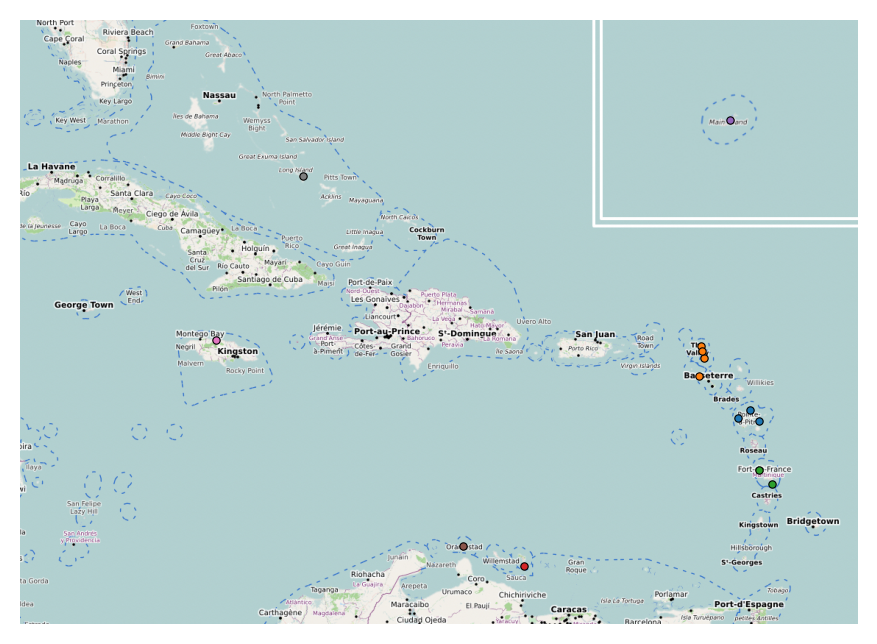

In [67]:
# Open image file
try :
    image = Image.open('/nfs/cube2/home/nthellier/carimam/cartefinale.jpg')
except :
    image = Image.open('/home/nthellier/carimam/cartefinale.jpg')

#image=[]
image = np.array(image)

# creation mask continents
eps = np.array([3,3,3])
mask = ((image < image[500,500,:] - eps) | (image > image[500,500,:] + eps))

# Our 2-dimensional distribution will be over variables X and Y (1139, 821)
#N = 40
X = np.linspace(0, 1138, 1139)
Y = np.linspace(0, 820, 821)
X, Y = np.meshgrid(X, Y)

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y


# creation figure
fig=plt.figure(dpi=my_dpi)
ax=fig.add_subplot(111)
divider = make_axes_locatable(ax)
ax.axis('off')

# ajout du fond de la carte
ax.imshow(image)

# ajout des stations
for station in stations_location :
    ax.scatter(stations_location[station][0],stations_location[station][1],color=stations_location[station][2], s=7, linewidth=0.4, edgecolors= "black")


# affichage + fermeture fig
plt.show(fig)
plt.close(fig)



In [68]:
# fake dataset

dummy = pd.DataFrame(np.array([[1,'StBARTH',40],[1,'GUA_AB',10],[1,'MART_StANNE',23],[2,'StBARTH',10],[2,'GUA_AB',23],[2,'BERMUDE',40]]),columns=['cluster','station','pred'])
dummy['cluster'] = dummy['cluster'].astype(int)
dummy['pred'] = dummy['pred'].astype(int)
dummy['station'] = dummy['station'].astype(str)
dummy.dtypes
print(dummy)

df = dummy.copy()

   cluster      station  pred
0        1      StBARTH    40
1        1       GUA_AB    10
2        1  MART_StANNE    23
3        2      StBARTH    10
4        2       GUA_AB    23
5        2      BERMUDE    40


In [69]:
# calcul des densités + normalisation

les_clusters = np.unique(dummy['cluster'])
map_data=[]
for id_c, c in enumerate(les_clusters) :
    dftemp = df[df['cluster'] == c]
    totalpred = dftemp['pred'].sum()
    
    for i in range(len(dftemp)) :
            
        raw = dftemp.iloc[i]

        #center of gaussian
        mu = stations_location[raw.station][0:2]
        #weight = raw[sp+'_norm']
        weight = raw['pred'] / totalpred

        #print(mu,weight)
        F = multivariate_normal(mu, sigma)
        tmppdf = weight * F.pdf(pos)
        normfactor = weight / np.max(tmppdf)
        tmppdf = tmppdf*normfactor
        
        if i == 0 :
            Z = tmppdf
        else :
            Z = Z + tmppdf

    # application du masque image pour que pdf ne couvre pas les continents
    Zprim = Z.reshape((image.shape[0],image.shape[1],1))
    Zprim = np.concatenate((Zprim,Zprim,Zprim), axis=2)
    #np.putmask(Zprim, ((image < image[500,500,:] - eps) | (image > image[500,500,:] + eps)), np.array([np.min(Z),np.min(Z),np.min(Z)]))
    np.putmask(Zprim, mask, np.array([np.min(Z),np.min(Z),np.min(Z)]))


    Zfinal = Zprim[:,:,0]

    #Zfinal = np.log(Zfinal+0.005)

    map_data.append([title+'_'+str(c), Zfinal])
        


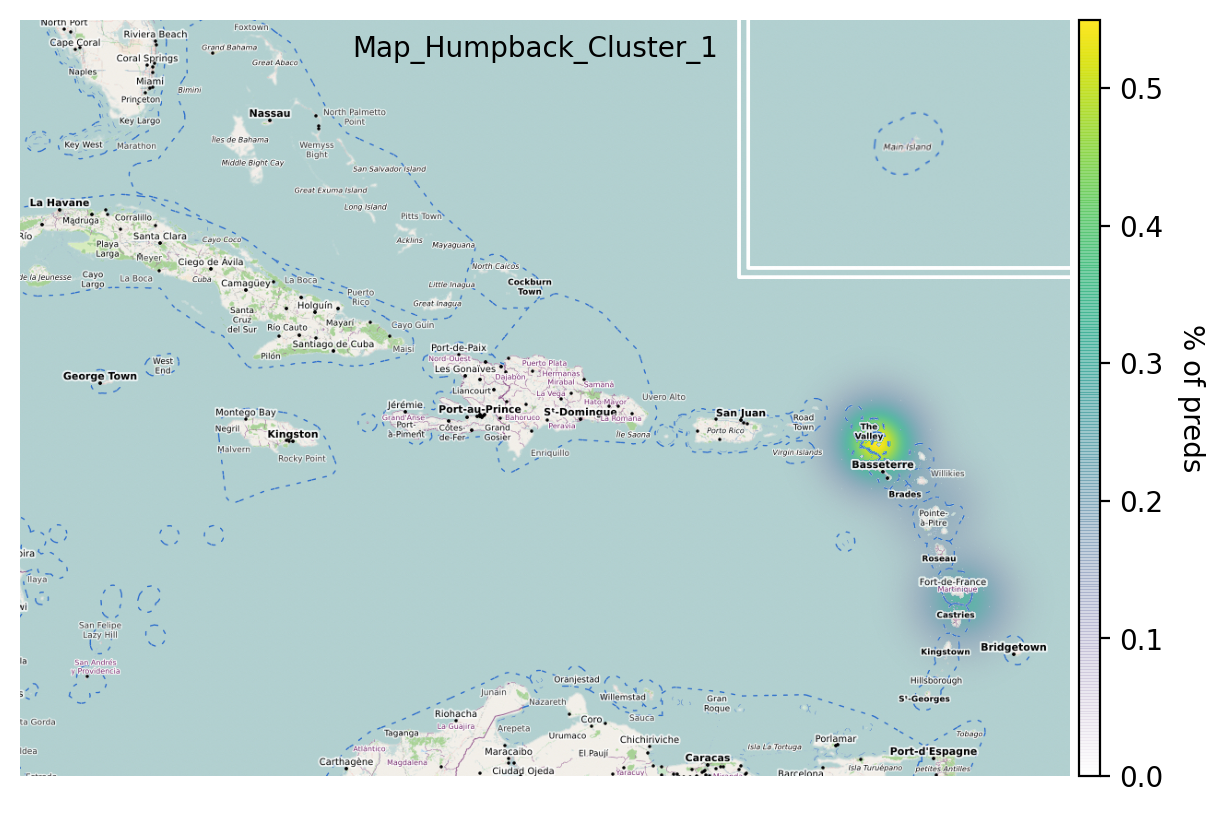

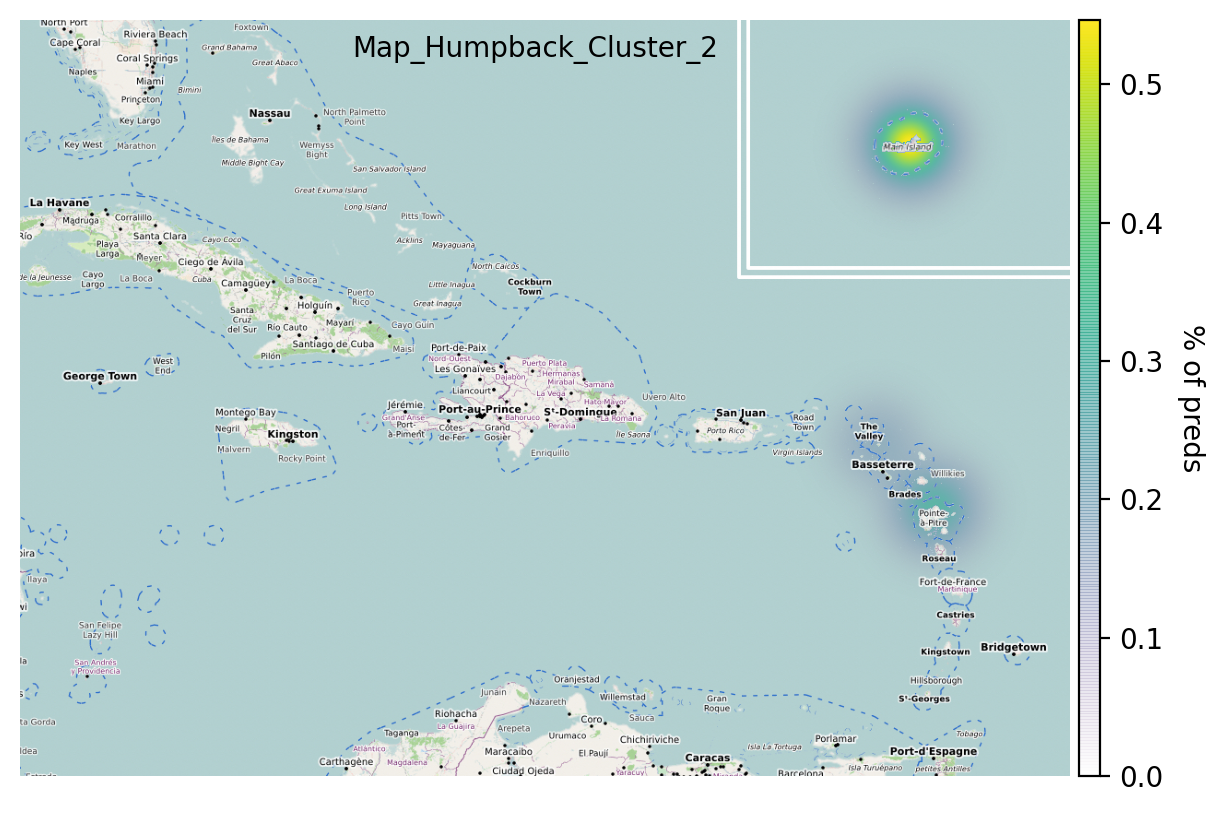

In [70]:
# affichage des cartes

for mapd in map_data :
    
    fig=plt.figure(dpi=my_dpi)
    ax=fig.add_subplot(111)
    divider = make_axes_locatable(ax)
    ax.axis('off')
    ax.imshow(image)
    ax.text(360,40,mapd[0])
    #ax.scatter(port[0],port[1], s=1)
    #ax.imshow(np.log(Znorm+0.1), cmap = transparent_cmap('viridis'))
    #mappable = ax.imshow(np.log(mapd[2]+0.005), cmap = transparent_cmap('viridis'))
    mappable = ax.imshow(mapd[1], cmap = transparent_cmap('viridis'))


    #ax2=fig.add_subplot(122)
    #cbar = fig.colorbar(mappable, fraction = 0.03, pad=0.01)
    #cbar = fig.colorbar(mappable, pad=0.01)
    cax = divider.append_axes("right", size="2%", pad=0.05)
    
    cbar = fig.colorbar(mappable, cax=cax, pad=0.01)

    cbar.set_label(legend_cbar, rotation=270, labelpad=15)
    fig.subplots_adjust(0,0,0.90,1)
    
    # uncomment to save
    #fig.savefig(mapd[0]+".jpg",dpi=my_dpi)